# Ex1 Linear Regression

## Import libraries

In [12]:
import pandas as pd
import seaborn as sns
sns.set(context="notebook", style="whitegrid", palette="dark")
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

## Read data

In [13]:
path =  'data/ex1data1.txt'
data = pd.read_csv(path, header=None, names=['Population', 'Profit'])
data.head()

,Population,Profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


In [14]:
data.describe()

,Population,Profit
count,97.000000,97.000000
mean,8.159800,5.839135
std,3.869884,5.510262
min,5.026900,-2.680700
25%,5.707700,1.986900
50%,6.589400,4.562300
75%,8.578100,7.046700
max,22.203000,24.147000


## Data Visualization

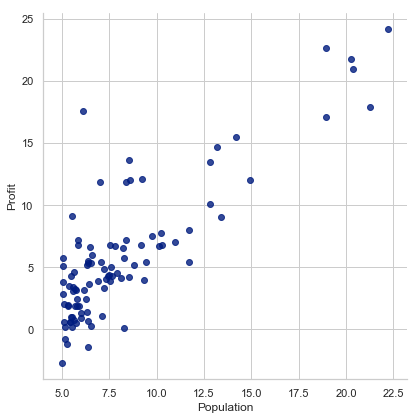

In [20]:
sns.lmplot('Population', 'Profit', data, height=6, fit_reg=False)
plt.show()

In [77]:
# Read Data
def get_X(data):
#     """
#     use concat to add intersect feature to avoid side effect
#     not efficient for big dataset though
#     """
    ones = pd.DataFrame({'ones': np.ones(len(data))}) # ones are m colum 1st row dataframe
    data = pd.concat([ones, data], axis=1)  # combining data by columns
    return data.iloc[:, :-1].values  # return ndarray, not the matrix

def get_y(data):
#     '''assume the last column is the target'''
    return np.array(data.iloc[:, -1]) #df.iloc[:, -1] is last column of data



In [63]:
# This function is writern by Lucas Shen

def linear_regression(X_data, y_data, alpha, epoch, optimizer=tf.train.GradientDescentOptimizer):
      # placeholder for graph input
    X = tf.placeholder(tf.float32, shape=X_data.shape)
    y = tf.placeholder(tf.float32, shape=y_data.shape)

    # construct the graph
    with tf.variable_scope('linear-regression'):
        W = tf.get_variable("weights",
                            (X_data.shape[1], 1),
                            initializer=tf.constant_initializer())  # n*1

        y_pred = tf.matmul(X, W)  # m*n @ n*1 -> m*1

        loss = 1 / (2 * len(X_data)) * tf.matmul((y_pred - y), (y_pred - y), transpose_a=True)  # (m*1).T @ m*1 = 1*1

    opt = optimizer(learning_rate=alpha)
    opt_operation = opt.minimize(loss)

    # run the session
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        loss_data = []

        for i in range(epoch):
            _, loss_val, W_val = sess.run([opt_operation, loss, W], feed_dict={X: X_data, y: y_data})
            loss_data.append(loss_val[0, 0])  # because every loss_val is 1*1 ndarray

            if len(loss_data) > 1 and np.abs(loss_data[-1] - loss_data[-2]) < 10 ** -9:  # early break when it's converged
                # print('Converged at epoch {}'.format(i))
                break

    # clear the graph
    tf.reset_default_graph()
    return {'loss': loss_data, 'parameters': W_val}  # just want to return in row vector format

In [64]:
data.head()

,Population,Profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


## Cost Function

$$J\left( \theta  \right)=\frac{1}{2m}\sum\limits_{i=1}^{m}{{{\left( {{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}} \right)}^{2}}}$$

\\[{{h}_{\theta }}\left( x \right)={{\theta }^{T}}X={{\theta }_{0}}{{x}_{0}}+{{\theta }_{1}}{{x}_{1}}+{{\theta }_{2}}{{x}_{2}}+...+{{\theta }_{n}}{{x}_{n}}\\] 

## Get features X and output y

In [65]:
X = get_X(data)
print(X.shape, type(X))

y = get_y(data)
print(y.shape, type(y))


(97, 2) <class 'numpy.ndarray'>
(97,) <class 'numpy.ndarray'>


In [66]:
theta = np.zeros(X.shape[1])
#X.shape[1]=2 because X has only 2 features

In [67]:
def lr_cost(theta, X, y):
#     """
#     X: R(m*n), m 
#     y: R(m)
#     theta : R(n)
#     """
    m = X.shape[0] 

    inner = X @ theta - y  # R(m*1)，X @ theta equals to X.dot(theta)

    # 1*m @ m*1 = 1*1 in matrix multiplication
    # but you know numpy didn't do transpose in 1d array, so here is just a
    # vector inner product to itselves
    square_sum = inner.T @ inner
    cost = square_sum / (2 * m)

    return cost

In [68]:
lr_cost(theta, X, y) # return value of theta

32.07273387745567

## batch gradient decent

$${{\theta }_{j}}:={{\theta }_{j}}-\alpha \frac{\partial }{\partial {{\theta }_{j}}}J\left( \theta  \right)$$


In [69]:
def gradient(theta, X, y):
    m = X.shape[0]

    inner = X.T @ (X @ theta - y)  # (m,n).T @ (m, 1) -> (n, 1)，X @ theta等价于X.dot(theta)

    return inner / m

def batch_gradient_decent(theta, X, y, epoch, alpha=0.01):

    cost_data = [lr_cost(theta, X, y)]
    _theta = theta.copy()  # get a coy of θ

    for _ in range(epoch):
        _theta = _theta - alpha * gradient(_theta, X, y)
        cost_data.append(lr_cost(_theta, X, y))

    return _theta, cost_data

In [70]:
epoch = 500
final_theta, cost_data = batch_gradient_decent(theta, X, y, epoch)

In [71]:
lr_cost(final_theta, X, y)

4.7138095311168655

# Plot cost data

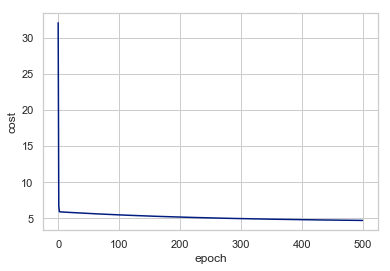

In [72]:
ax= sns.lineplot(x=np.arange(epoch+1),y=cost_data)
ax.set_xlabel('epoch')
ax.set_ylabel('cost')
plt.show()


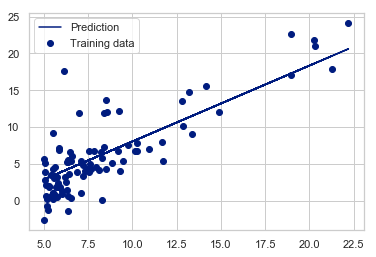

In [73]:
b = final_theta[0] # intercept 
m = final_theta[1] # slope

plt.scatter(data.Population, data.Profit, label="Training data")
plt.plot(data.Population, data.Population*m + b, label="Prediction")
plt.legend(loc=2)
plt.show()

# Optional EX

In [75]:
raw_data = pd.read_csv('data/ex1data2.txt', names=['square', 'bedrooms', 'price'])
raw_data.head()

,square,bedrooms,price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


In [78]:
def normalize_feature(data):
#     """Applies function along input axis(default 0) of DataFrame."""
#      Feature scaling
    return data.apply(lambda column: (column - column.mean()) / column.std()) # feature scaling


data = normalize_feature(raw_data)
data.head()

,square,bedrooms,price
0,0.130010,-0.223675,0.475747
1,-0.504190,-0.223675,-0.084074
2,0.502476,-0.223675,0.228626
3,-0.735723,-1.537767,-0.867025
4,1.257476,1.090417,1.595389


## multi-var batch gradient decent

In [79]:
X = get_X(data)
print(X.shape, type(X))

y = get_y(data)
print(y.shape, type(y))

(47, 3) <class 'numpy.ndarray'>
(47,) <class 'numpy.ndarray'>


In [80]:
alpha = 0.01 # Learning Rate
theta = np.zeros(X.shape[1])#X.shape[1]：Amount of Features
epoch = 500 

In [82]:
final_theta, cost_data = batch_gradient_decent(theta, X, y, epoch, alpha=alpha)

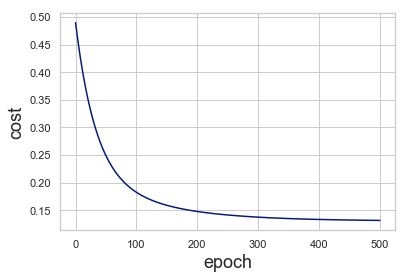

In [83]:
sns.lineplot(x=np.arange(len(cost_data)), y = cost_data)
plt.xlabel('epoch', fontsize=18)
plt.ylabel('cost', fontsize=18)
plt.show()

In [84]:
final_theta

array([-1.18994649e-16,  8.30383883e-01,  8.23982853e-04])

## learning rate

In [86]:
base = np.logspace(-1, -5, num=4)
candidate = np.sort(np.concatenate((base, base*3)))
print(candidate)


[1.00000000e-05 3.00000000e-05 2.15443469e-04 6.46330407e-04
 4.64158883e-03 1.39247665e-02 1.00000000e-01 3.00000000e-01]


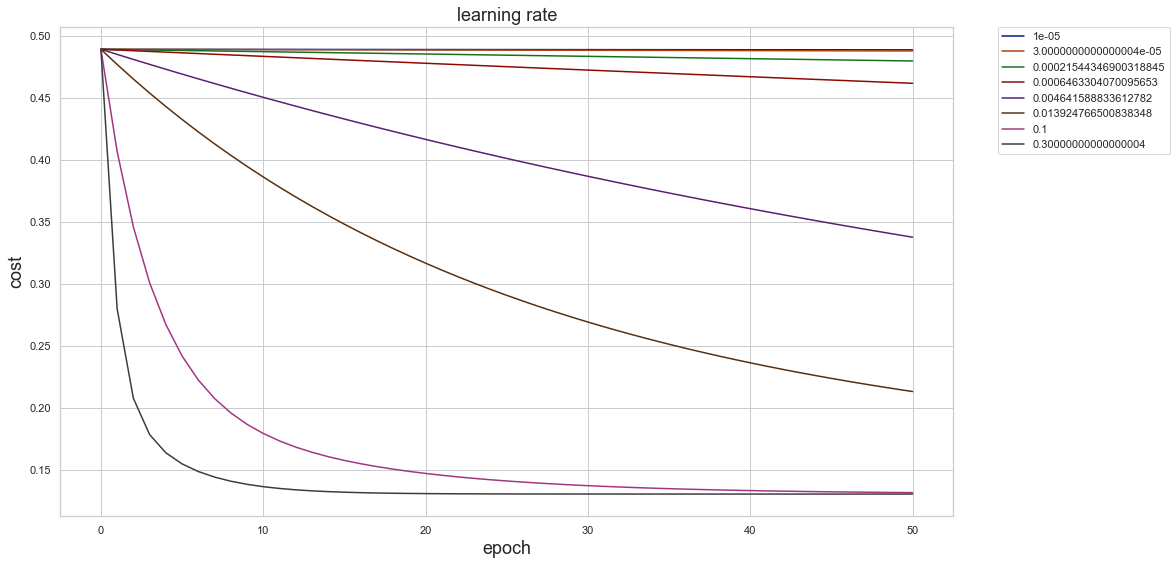

In [87]:
epoch=50

fig, ax = plt.subplots(figsize=(16, 9))

for alpha in candidate:
    _, cost_data = batch_gradient_decent(theta, X, y, epoch, alpha=alpha)
    ax.plot(np.arange(epoch+1), cost_data, label=alpha)

ax.set_xlabel('epoch', fontsize=18)
ax.set_ylabel('cost', fontsize=18)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('learning rate', fontsize=18)
plt.show()

## normal equation

In [88]:
def normalEqn(X, y):
    theta = np.linalg.inv(X.T@X)@X.T@y #X.T@X equals to X.T.dot(X)
    return theta

In [89]:
final_theta2=normalEqn(X, y)
final_theta2

array([-1.04083409e-16,  8.84765988e-01, -5.31788197e-02])

Comparing to multi-var gradient decent which has

array([-1.18994649e-16,  8.30383883e-01,  8.23982853e-04])

This one has little difference


## run the tensorflow graph over several optimizer

In [90]:
X_data = get_X(data)
print(X_data.shape, type(X_data))

y_data = get_y(data).reshape(len(X_data), 1)  # special treatment for tensorflow input data
print(y_data.shape, type(y_data))

(47, 3) <class 'numpy.ndarray'>
(47, 1) <class 'numpy.ndarray'>


In [91]:
epoch = 2000
alpha = 0.01
optimizer_dict={'GD': tf.train.GradientDescentOptimizer,
                'Adagrad': tf.train.AdagradOptimizer,
                'Adam': tf.train.AdamOptimizer,
                'Ftrl': tf.train.FtrlOptimizer,
                'RMS': tf.train.RMSPropOptimizer
               }
results = []
for name in optimizer_dict:
    res = linear_regression(X_data, y_data, alpha, epoch, optimizer=optimizer_dict[name])
    res['name'] = name
    results.append(res)

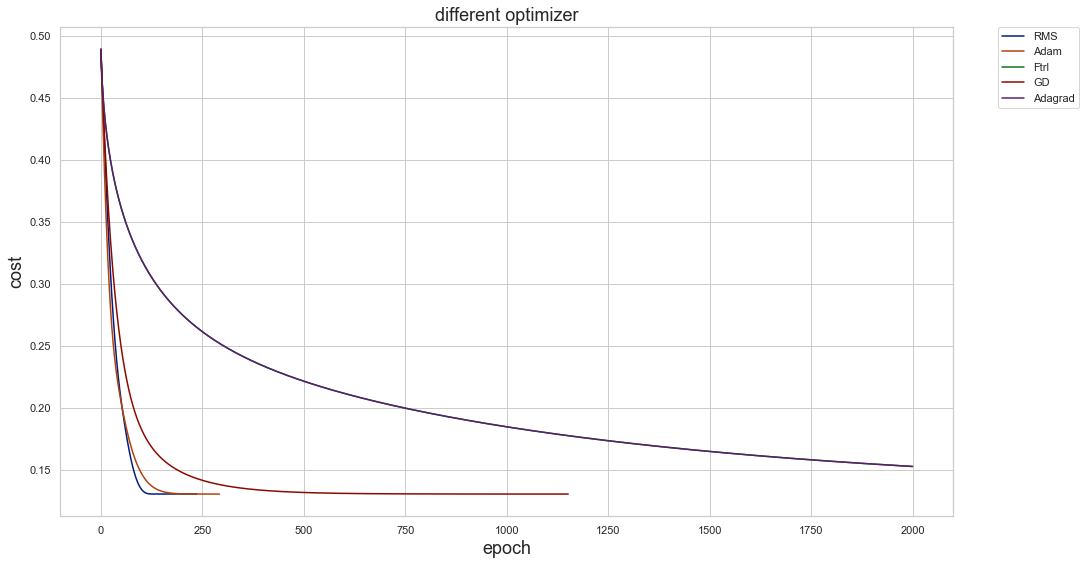

In [92]:
fig, ax = plt.subplots(figsize=(16, 9))

for res in results: 
    loss_data = res['loss']
    
#     print('for optimizer {}'.format(res['name']))
#     print('final parameters\n', res['parameters'])
#     print('final loss={}\n'.format(loss_data[-1]))
    ax.plot(np.arange(len(loss_data)), loss_data, label=res['name'])

ax.set_xlabel('epoch', fontsize=18)
ax.set_ylabel('cost', fontsize=18)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('different optimizer', fontsize=18)
plt.show()